In [1]:
# Imports
import os
import dill
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score

In [2]:
# Load dataset
data = pd.read_csv("../data/02_engineered_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PERSON_ID                16048 non-null  int64  
 1   WEIGHT                   16048 non-null  float64
 2   GENDER                   16048 non-null  object 
 3   NUMBER_OF_CHILDREN       16048 non-null  int64  
 4   AGE                      16048 non-null  int64  
 5   HOUSEHOLD_SIZE           16048 non-null  int64  
 6   TV_TOTAL                 16048 non-null  float64
 7   FLYERS                   16048 non-null  float64
 8   PRINT_TOTAL              16048 non-null  float64
 9   ONLINE_VIDEO             16048 non-null  float64
 10  ONLINE_DISPLAY           16048 non-null  float64
 11  ONLINE_TOTAL             16048 non-null  float64
 12  TIKTOK                   16048 non-null  float64
 13  YOUTUBE_TOTAL            16048 non-null  float64
 14  YOUTUBE_MOBILE        

## 1. Data Pre-Proccessing

In [4]:
# Get dummies for gender
data = pd.get_dummies(data, columns=['GENDER'], drop_first=True)  # Drop one category to avoid multicollinearity

In [5]:
# List of all features in the dataset for easy selection
train_features = [
    # 'PERSON_ID',
    # 'WEIGHT',
    'GENDER_MALE',
    'GENDER_UNKNOWN',
    'NUMBER_OF_CHILDREN',
    'AGE',
    'HOUSEHOLD_SIZE',
    'TV_TOTAL',
    'FLYERS',
    'PRINT_TOTAL',
    'ONLINE_VIDEO',
    'ONLINE_DISPLAY',
    'ONLINE_TOTAL',
    'TIKTOK',
    'YOUTUBE_TOTAL',
    'YOUTUBE_MOBILE',
    'YOUTUBE_DESKTOP',
    'YOUTUBE_TABLET',
    'YOUTUBE_CTV',
    'PINTEREST',
    # 'PURCHASE',
    'OUTLIER_SCORE',
    'TOTAL_MEDIA_EXPOSURE',
    'DIGITAL_MEDIA_TOTAL',
    'TRADITIONAL_MEDIA_TOTAL',
    # 'AGE_GROUP',
    'HEAVY_MEDIA_USER'
]


In [6]:
# Split data into features and labels
X = data[train_features]
y = data['PURCHASE']  # Target variable
weights = data['WEIGHT']  # Store sample weights separately

# Shape check
X.shape, y.shape, weights.shape

((16048, 23), (16048,), (16048,))

### Train/Test split

I want to make sure and split the data before applying scaling otherwise if we were to scale the data before splitting, information from the test set will leak into the training process. This would give the model an unfair advantage and could lead to overfitting. Scaling after the split ensures that the scaling process only considers the training data, which should mirror real-world conditions where we would only have access to the training data to train our model.

In [7]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

### Data Scaling

- The features in this dataset don't contain particularly large values, but scaling remains an easy and effective way to enhance model performance, so it's worth utilizing. However, I'll be excluding binary and boolean features from scaling, since that could distort their meaning without adding value to model performance and is unlikely to improve accuracy.

- Scaling the weights should not be required since they adjust the loss function on a per-observation basis and it shouldn't matter if the values vary significantly as long as they are consistent in their relative importance.

In [8]:
# List of columns to not scale (categorical and/or binary columns)
exclude_columns = ['PERSON_ID', 'TARGET_GROUP', 'OUTLIER_SCORE', 'HEAVY_MEDIA_USER', 'ENGAGED_VIDEO_USER']

# List of all columns in the dataframe
all_columns = X_train.columns.tolist()

# Columns to scale: all columns except the ones to exclude
columns_to_scale = [col for col in all_columns if col not in exclude_columns]

# Initialize scaler
scaler = StandardScaler()

# Scale specific features in train and test data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

## 2. Preliminary Model Selection

We will run cross-validation on several models that are expected to perform well on this dataset. For this task, it is crucial to minimize misclassifications: false positives lead to unnecessary marketing spend on unlikely purchasers, while false negatives mean missing potential buyers. Given that missing a purchaser is more costly—especially when a campaign is already underway—our focus will be on models that maximize recall without sacrificing overall performance. 

That being said, for an initial overview I will go with a more balanced approach and use **F1 score** as my initial metric.



In [9]:
def model_evaluation(models: dict, X_train, y_train, w_train=None):
    """
    This function uses Cross Validation to evaluate models' perfomence. Returns a report of the models' names and mean scores.
    """

    evaluation_report = {}
    for model_name, model in models.items():

        cv = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring="f1", 
            # fit_params={'sample_weight': w_train},
            n_jobs=-1
        )

        evaluation_report[model_name] = cv.mean()
        
        cv_rounded = [f"{round(score * 100, 1)}%" for score in cv]
        cv_mean = f"{round(cv.mean() * 100, 1)}%"
        
        print(f"{model_name}:\n- CV F1 scores: {' | '.join([item for item in cv_rounded])}\n- CV mean: {cv_mean}\n")

    return evaluation_report


# Models for preliminary testing
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'LinearSVC': LinearSVC(random_state=42),
}

In [10]:
_ = model_evaluation(models, X_train_scaled, y_train, w_train)

Logistic Regression:
- CV F1 scores: 69.3% | 63.2% | 65.7% | 65.2% | 66.3%
- CV mean: 65.9%

Random Forest Classifier:
- CV F1 scores: 65.9% | 61.8% | 64.0% | 61.8% | 65.5%
- CV mean: 63.8%

GradientBoostingClassifier:
- CV F1 scores: 67.8% | 61.9% | 65.7% | 63.9% | 67.0%
- CV mean: 65.3%

KNeighbors Classifier:
- CV F1 scores: 64.6% | 58.7% | 62.7% | 60.7% | 62.1%
- CV mean: 61.8%

LinearSVC:
- CV F1 scores: 70.1% | 64.2% | 66.6% | 65.4% | 67.5%
- CV mean: 66.8%



## 3. Model Tuning and Optimization

Our initial experiments with several models have yielded decent results:

- **Logistic Regression:**  
  This model currently scores the highest, suggesting that much of the underlying data correlation is linearly separable. It merits further exploration and fine-tuning.

- **Random Forest:**  
  One of my favorites, Random Forest has shown strong performance and robustness. Although its score is slightly lower than Logistic Regression, I plan to experiment with hyperparameter tuning to potentially boost its performance.

- **Gradient Boosting Classifier:**  
  A consistently solid choice, the Gradient Boosting Classifier appears well-suited to this task, offering a good balance between performance and interpretability.

- **Support Vector Classifier (SVC):**  
  SVC is a powerful model; however, incorporating sample weights significantly increases processing time. While techniques like dimensionality reduction might mitigate this issue, I will prioritize the other models first before further exploring SVC.

### 3.0 Support Functions

I will start by setting up some functions to make my life easier down the line.

#### 3.0.1 Grid Search

**Grid Seach** makes tuning hyper parameters easy and streight forward. I want to set up a functio nthat will allow me to apply the search to multitude of models easily. Additionally, so far we have not accounted for the **sampel weights** provided in the dataset. Grid Search does support that functionality so let's start by setting up a function to make tuning all models easier and more streamlined.

As mentioned previously, the precission-recall tradeoff will be of vital importance so I will stick with F1 as the main socring matric for the grid search. I also want to be able to view the best performing hypeparameter settings and save the best model if desired. 

I will also incorporate **MLFlow** into the function for easy tracking of the model optimizations process.

In [11]:
# Set MLflow tracking directory to one level up (project root)
mlflow.set_tracking_uri("../mlruns")

In [12]:
def tune_params(model, X_train, X_test, y_train, y_test, w_train, w_test, param_grid, scoring='f1'):
    # Define a clear experiment name
    experiment_name = f"Exp_{model.__class__.__name__}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    mlflow.set_experiment(experiment_name)  # Set experiment name explicitly

    # Define a custom run name for easier tracking
    run_name = f"{model.__class__.__name__}_Run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"

    with mlflow.start_run(run_name=run_name):
        # Log basic model parameters
        mlflow.log_param("model_type", model.__class__.__name__)

        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring,
            cv=5,
            n_jobs=-1,
        )

        # Fit the model
        grid_search.fit(X_train, y_train, sample_weight=w_train)

        # Get the best model
        best_model = grid_search.best_estimator_

        # Predict on test set and compute weighted F1 score
        y_pred = best_model.predict(X_test)
        weighted_f1 = f1_score(y_test, y_pred, sample_weight=w_test)

        # MLFlow Logging
        mlflow.log_metric("weighted_f1", weighted_f1)  
        mlflow.log_params(grid_search.best_params_)  
        mlflow.sklearn.log_model(best_model, f"Tuned_{model.__class__.__name__}", input_example=X_train.iloc[:20])

        # Print results
        print("----------------------------------------")
        print(f"Weighted F1 Score: {round(weighted_f1, 2)}")
        print("Best Parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"{param}: {value}")
        print("----------------------------------------")
        
        return best_model

#### 3.0.2 Model Evaluation

To efficiently evaluate the performance of each model, I'll set up a function that provides a comprehensive overview. The F1 score will be prioritized, as it offers a balanced measure of precision and recall, which is crucial for this task. Additionally, I'll include a classification report, which provides detailed insights into precision, recall, and support for each class. Finally, a confusion matrix will be used to visually assess the model’s predictions, providing concrete numbers behind the performance metrics.

In [13]:
def evaluate_model_performance(model, X, y, w_test):
    """
    Evaluates the model performance using weighted ROC AUC, a weighted classification report,
    and a weighted confusion matrix heatmap.

    Args:
        model: Trained model (e.g., SVC, RandomForest, etc.)
        X: Features (DataFrame or array-like)
        y: True labels (array-like)
        w_test: Sample weights corresponding to each observation in X and y
        
    Returns:
        None
    """
    # Make predictions
    y_pred = model.predict(X)
    # y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class

    # custom_threshold = 0.3
    # y_prob = (y_prob >= custom_threshold).astype(int)

    # Calculate and print the weighted ROC AUC score
    print("||---------------------------------------------------------------------")
    metric_score = f1_score(y, y_pred, sample_weight=w_test)
    print(f"Weighted F1 score Score: {metric_score:.4f}")

    # Generate and print the weighted classification report
    print("||---------------------------------------------------------------------")
    class_report = classification_report(y, y_pred, sample_weight=w_test)
    print("\nWeighted Classification Report:\n", class_report)
    
    # Compute the weighted confusion matrix
    print("||---------------------------------------------------------------------")
    cm = confusion_matrix(y, y_pred, sample_weight=w_test)
    
    # Plot the weighted confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', 
                xticklabels=['Pred: No', 'Pred: Yes'], 
                yticklabels=['True: No', 'True: Yes'], cbar=False)
    plt.title('Weighted Confusion Matrix Heatmap')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


#### 3.0.3 Save Model
A function to save models in the `models/` folder for future use.

In [14]:
def save_model(model, model_name, models_folder="..\models"):
    """
    Saves a trained model to the specified folder using dill.

    Args:
        model: The trained model to save.
        model_name (str): The name of the file (e.g., "best_model.pkl").
        models_folder (str): The folder in which to save the model (default is "models").

    Returns:
        str: The full path to the saved model file.
    """
    # Create the models folder if it doesn't exist.
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
    
    # Construct the full file path.
    model_path = os.path.join(models_folder, model_name)
    
    # Save the model using dill.
    with open(model_path, 'wb') as file:
        dill.dump(model, file)
    print(f"Model saved to: {model_path}")
    
    # return model_path

#### 3.0.4 Load Model
A function for loading a saved model.

In [15]:
import os
import dill

def load_model(model_name, models_folder="..\\models"):
    """
    Loads a model from the specified folder using dill.

    Args:
        model_name (str): The name of the model file to load (e.g., "best_model.pkl").
        models_folder (str): The folder from which to load the model (default is "..\\models").

    Returns:
        The loaded model if successful; None otherwise.
    """
    # Construct the full file path.
    model_path = os.path.join(models_folder, model_name)
    
    try:
        with open(model_path, 'rb') as file:
            model = dill.load(file)
        print(f"Model loaded from: {model_path}")
        return model
    except Exception as e:
        print(f"Unable to load model from: {model_path}. Error: {e}")
        return None


#### 3.0.5 Feature Importances
Visualizing feature importances is crucial for understanding which features a model considers most valuable. This insight helps identify and filter out less informative features, reducing the dataset size while retaining the majority of relevant information. As a result, we can train models more efficiently without sacrificing accuracy. Additionally, it provides guidance on which features to prioritize in future campaigns, enabling more targeted and effective marketing strategies.

In [16]:
def display_feature_importances(model, dataframe):
    # Get feature importance
    importance_df = pd.DataFrame({
        'Feature': dataframe.columns,
        'Importance': model.feature_importances_
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the top most important features
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Top Feature Importances from {type(model).__name__}')
    plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
    plt.show()

### 3.1 Logistic Regression

Let's start by attempting to squeeze a bit more performance out of LR. It's a simplistic model, quick to tune and will give us a general idea of what can be expect out of this dataset. So far we have not accounted for the **sampel weights** provided in the dataset. **Grid Search** does support that functionality so let's start by setting up a function to make reusing grid search on other models easier and more streamlined.

In [17]:
# # Initialize the model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Define hyperparameter grid for tuning
lr_param_grid = {
    'max_iter' : [4, 10, 50, 100],
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Optimizer
    'penalty': ['l1', 'l2'],  # Regularization type
}

best_lr = tune_params(lr, X_train_scaled, X_test_scaled, y_train, y_test, w_train, w_test, lr_param_grid)

2025/02/14 11:02:51 INFO mlflow.tracking.fluent: Experiment with name 'Exp_LogisticRegression_2025-02-14_11-02-51' does not exist. Creating a new experiment.


----------------------------------------
Weighted F1 Score: 0.63
Best Parameters:
C: 1
max_iter: 50
penalty: l1
solver: liblinear
----------------------------------------


||---------------------------------------------------------------------
Weighted F1 score Score: 0.6311
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.77      0.72 8922994.970000016
        True       0.69      0.58      0.63 7791340.720000001

    accuracy                           0.68 16714335.690000016
   macro avg       0.68      0.68      0.68 16714335.690000016
weighted avg       0.68      0.68      0.68 16714335.690000016

||---------------------------------------------------------------------


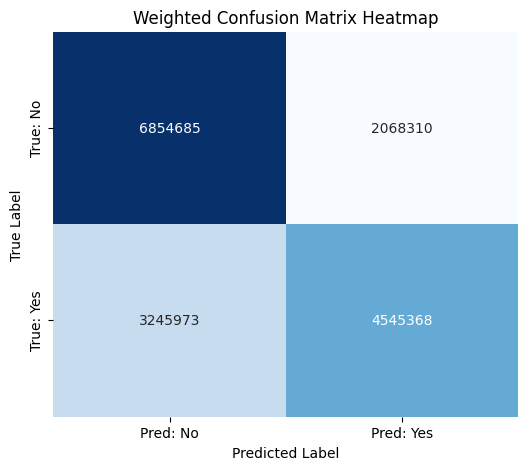

In [18]:
#  Check results
evaluate_model_performance(best_lr, X_test_scaled, y_test, w_test)

#### Model Scoring Philosophy and Improvements

The Logistic Regression model shows limited improvement after hyperparameter tuning, suggesting that it has reached its potential with this dataset. It likely captured the general relationship early on but lacks the capacity to capture more complex nuances in the data. As a result, we will need to explore more sophisticated models. 

The low recall for the positive class is particularly concerning. Even though the two classes have a near perfectly balanced distribution, the ultimate business goal is to identify the individuals who will make a purchase. I believe that missing potential buyers (false negatives) can be more costly than occasionally targeting someone who doesn’t purchase (false positives). Therefore, it makes sense to focus on maximizing recall for the positive class as it will mean catching as many potential purchasers as possible. In the context of an advertising campaign, we want to ensure that our model doesn’t overlook valuable customers. This approach supports a more aggressive targeting strategy, as was suggested during the data analysis, as I believe that could translate into higher revenue.

### 3.2 Random Forrest

Random Forest is a natural next step due to its increased capability to capture complex relationships and interactions within the data. Given its flexibility and ability to handle non-linearities, it should provide a better fit and improve performance compared to Logistic Regression.

Let’s address the low recall on the positive class by applying class weights. By assigning a higher weight to the positive class, we can better balance the model’s focus, improving recall and aligning more closely with the objectives of the task.

In [19]:
# Load model
best_rf = load_model("3.2_best_rf.pkl")

Unable to load model from: ..\models\3.2_best_rf.pkl. Error: [Errno 2] No such file or directory: '..\\models\\3.2_best_rf.pkl'


In [20]:
if not best_rf:
    
    # Define custom class weights
    class_weights = {0: 0.375, 1: 0.625}

    # Initialize a random forest model
    rf = RandomForestClassifier(
        class_weight=class_weights, 
        random_state=42
        )

    # Define the hyperparameter grid for tuning
    rf_param_grid = {
        'n_estimators': [200, 400, 800],  # Number of trees
        'max_depth': [5, 10, 20],  # Max depth of trees
        'min_samples_split': [2, 5, 10],  # Min samples required to split an internal node
        'min_samples_leaf': [4, 8, 12],  # Min samples required to be at a leaf node
        'max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
    }

    # Hyperparam optimization
    best_rf = tune_params(rf, X_train_scaled, X_test_scaled, y_train, y_test, w_train, w_test, rf_param_grid)

    # Save best model
    save_model(best_rf, "3.2_best_rf.pkl")

2025/02/14 11:03:28 INFO mlflow.tracking.fluent: Experiment with name 'Exp_RandomForestClassifier_2025-02-14_11-03-28' does not exist. Creating a new experiment.


----------------------------------------
Weighted F1 Score: 0.65
Best Parameters:
max_depth: 5
max_features: sqrt
min_samples_leaf: 8
min_samples_split: 2
n_estimators: 400
----------------------------------------
Model saved to: ..\models\3.2_best_rf.pkl


||---------------------------------------------------------------------
Weighted F1 score Score: 0.6497
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.65      0.67 8922994.970000016
        True       0.63      0.68      0.65 7791340.720000001

    accuracy                           0.66 16714335.690000016
   macro avg       0.66      0.66      0.66 16714335.690000016
weighted avg       0.66      0.66      0.66 16714335.690000016

||---------------------------------------------------------------------


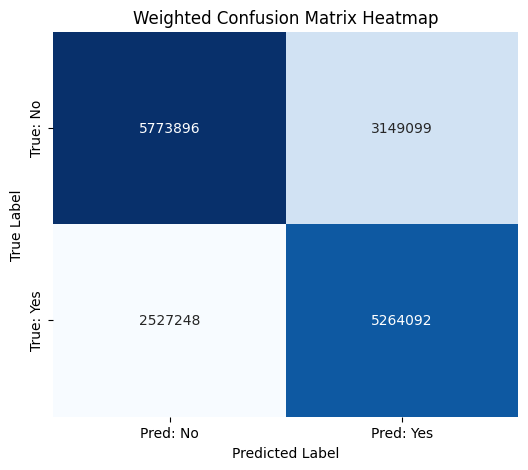

In [21]:
evaluate_model_performance(best_rf, X_test_scaled, y_test, w_test)

While applying class weights has reduced the overall F1 score, there has been a significant increase in recall for the positive class. This improvement is valuable, as it enhances our ability to correctly identify potential customers for targeted marketing efforts, aligning with our primary objective.

LKet;s take a look at the feature importances for this optimized Random Forrest model:

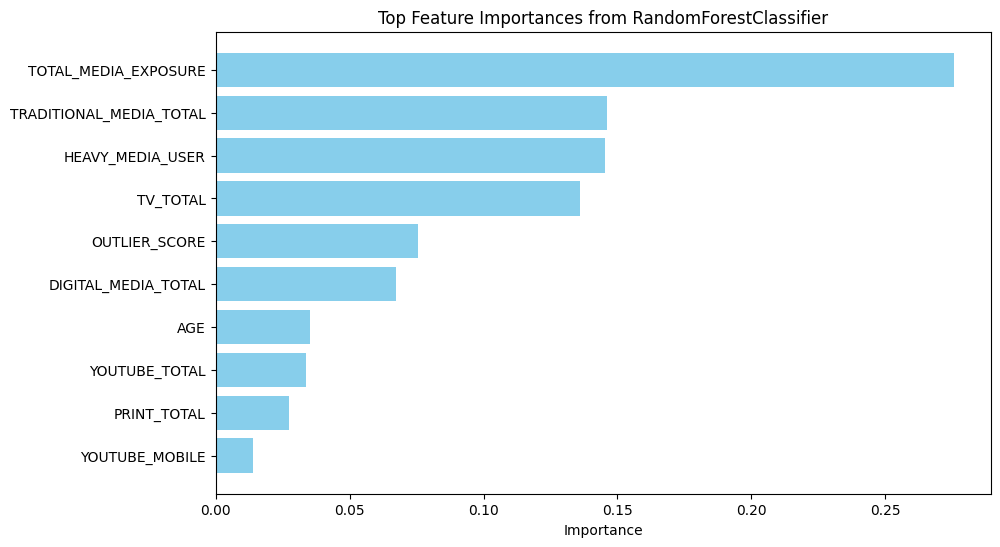

In [22]:
display_feature_importances(best_rf, X_train_scaled)

As highlighted in the data analysis, overall media exposure emerges as the key driver of purchase behavior. The number of observations per channel also plays a crucial role, with channels that have the most exposure contributing significantly to the results. `OUTLIER_SOCRE` is also among the top contributors which indicates there is indded some value in providing the model with information about the possible outliers in the data.

With these insights in mind, let's proceed to the next model and compare the outcomes.

### 3.3 Gradient Boosting Classifier

Gradient Boosting scored second highest, making it a promising candidate for further exploration. This model is known for its ability to capture complex relationships in the data through boosting, which could potentially improve predictive accuracy. Given its strong performance, it’s worth fine-tuning the hyperparameters to squeeze out any additional performance improvements. Let’s proceed with experimenting to see how it compares with the others.

In [23]:
best_gb = load_model("3.3_best_gb.pkl")

Unable to load model from: ..\models\3.3_best_gb.pkl. Error: [Errno 2] No such file or directory: '..\\models\\3.3_best_gb.pkl'


In [24]:
if not best_gb:

    # Initialize a Gradient Boosting model
    gb = GradientBoostingClassifier(
        validation_fraction=0.1,  # fraction of training data used for early stopping.
        n_iter_no_change=10,  # if no improvement in validation score for these many iterations, training stops
        tol=1e-4,  # tolerance for the early stopping criterion
        random_state=42
        )

    # Define the hyperparameter grid for tuning
    gb_param_grid = {
        'n_estimators': [50, 100, 200],       # Number of boosting stages
        'max_depth': [2, 4, 6],               # Maximum depth of each regression tree
        'learning_rate': [0.01, 0.05, 0.1],   # Learning rate shrinks the contribution of each tree
        'min_samples_split': [5, 10, 20],     # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 3, 5],        # Minimum number of samples required to be at a leaf node
        'subsample': [0.6, 0.8]                # Fraction of samples used for fitting each tree
    }

    # Tune hyperparams
    best_gb = tune_params(gb, X_train_scaled, X_test_scaled, y_train, y_test, w_train, w_test, gb_param_grid)

    # Save best performing model
    save_model(best_gb, "3.3_best_gb.pkl")

2025/02/14 11:06:57 INFO mlflow.tracking.fluent: Experiment with name 'Exp_GradientBoostingClassifier_2025-02-14_11-06-57' does not exist. Creating a new experiment.


----------------------------------------
Weighted F1 Score: 0.63
Best Parameters:
learning_rate: 0.1
max_depth: 2
min_samples_leaf: 5
min_samples_split: 5
n_estimators: 100
subsample: 0.8
----------------------------------------
Model saved to: ..\models\3.3_best_gb.pkl


||---------------------------------------------------------------------
Weighted F1 score Score: 0.6302
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.80      0.74 8922994.970000016
        True       0.71      0.56      0.63 7791340.720000001

    accuracy                           0.69 16714335.690000016
   macro avg       0.70      0.68      0.68 16714335.690000016
weighted avg       0.70      0.69      0.69 16714335.690000016

||---------------------------------------------------------------------


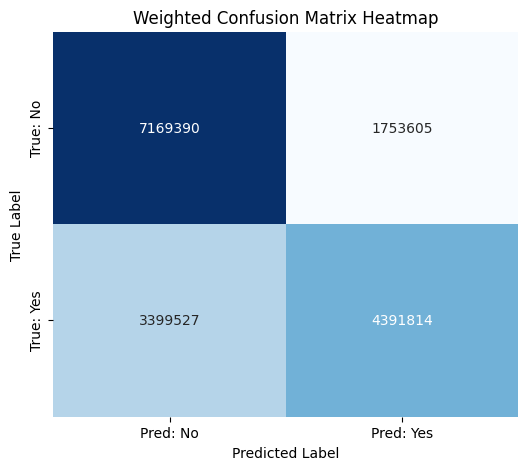

In [25]:
evaluate_model_performance(best_gb, X_test_scaled, y_test, w_test)

GradientBoosting shows a slight performance improvement over Random Forest. However, like the Logistic Regression model, it struggles with very low recall for the positive class when no class weights are applied. This indicates that the  the model is quite concervative with its predictions which is hindering its ability to correctly identify positive cases. I will stick to using class weights.

Let's take a look at the feature importances for this model as well:

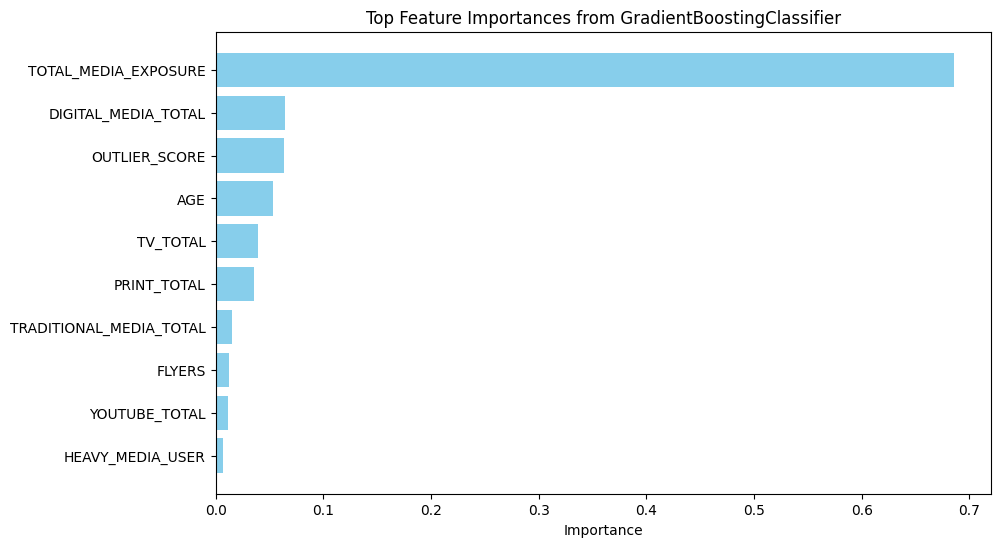

In [26]:
display_feature_importances(best_gb, X_train_scaled)

This model places a strong emphasis on total media exposure, further reinforcing the insights from our data analysis. The remaining features rank significantly lower in importance but still follow a similar pattern to what we observed with the Random Forest model.

### 3.4 LinearSVC

As mentioned previously, the data seem to be quite linear so I will go with a LinearSVC as the regular SVC is just too impractical for me to be able to run it in a reasonable timeframe.

Support Vector classifier did the best but wit hthe application of sample weights it is just way too slow for me to be able to run it in a reasonable timeframe

In [27]:
best_linear_svc = load_model("3.4_best_linear_svc.pkl")

Unable to load model from: ..\models\3.4_best_linear_svc.pkl. Error: [Errno 2] No such file or directory: '..\\models\\3.4_best_linear_svc.pkl'


In [28]:
if not best_linear_svc:

    # Define custom class weights
    class_weights = {0: 0.35, 1: 0.65}

    # Initialize LinearSVC
    linear_svc = LinearSVC(
        class_weight=class_weights, 
        random_state=42
        )

    # SVC param grid
    linear_svc_param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],           # Regularization strength: smaller values specify stronger regularization.
        'loss': ['hinge', 'squared_hinge'],      # Loss functions to try.
        'max_iter': [1000, 5000, 10000]           # Increase iterations to ensure convergence.
    }

    # Tune params
    best_linear_svc = tune_params(linear_svc, X_train_scaled, X_test_scaled, y_train, y_test, w_train, w_test, linear_svc_param_grid)

    # Save best model
    save_model(best_linear_svc, "3.4_best_linear_svc.pkl")

2025/02/14 11:10:07 INFO mlflow.tracking.fluent: Experiment with name 'Exp_LinearSVC_2025-02-14_11-10-07' does not exist. Creating a new experiment.


----------------------------------------
Weighted F1 Score: 0.66
Best Parameters:
C: 0.1
loss: squared_hinge
max_iter: 1000
----------------------------------------
Model saved to: ..\models\3.4_best_linear_svc.pkl


||---------------------------------------------------------------------
Weighted F1 score Score: 0.6578
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.71      0.55      0.62 8922994.970000016
        True       0.59      0.74      0.66 7791340.720000001

    accuracy                           0.64 16714335.690000016
   macro avg       0.65      0.65      0.64 16714335.690000016
weighted avg       0.65      0.64      0.64 16714335.690000016

||---------------------------------------------------------------------


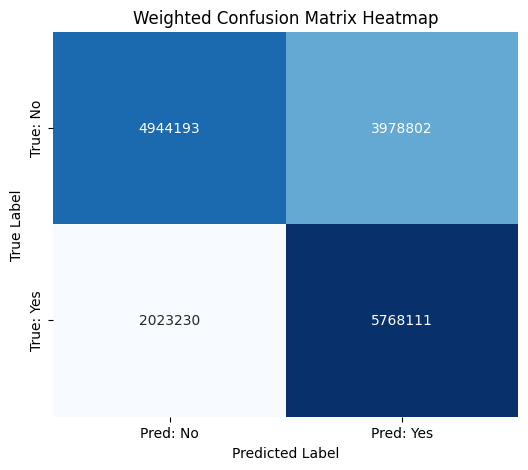

In [29]:
evaluate_model_performance(best_linear_svc, X_test_scaled, y_test, w_test)

LinearSVC has achieved the best overall performance. By applying a slightly more aggressive class weighting in favor of the positive class, we obtained results that are usable—although not as high as I had hoped.

## Summary and Conclusion

In this modeling section, we explored several machine learning approaches to predict purchases based on socio-demographic and media exposure features. Our initial experiments with Logistic Regression provided a solid baseline, indicating that the main relationships in the data are largely linear. However, the model struggled to capture the nuances necessary to maximize recall on the positive class.

To address this, we moved on to more sophisticated models such as Random Forest and Gradient Boosting. Random Forest demonstrated robust performance and provided valuable insights into feature importance, while Gradient Boosting further improved predictive accuracy. Despite these advances, we observed that without appropriate class weighting, even our best models suffered from lower recall for the positive class. By adjusting class and sample weights, we aimed to better capture potential purchasers—acknowledging that, for our marketing objectives, false negatives are particularly costly.

Additionally, we explored LinearSVC as a fast and efficient option.

Overall, our modeling efforts balanced several key aspects: achieving reasonable performance, optimizing recall for the positive class, and maintaining model interpretability for actionable insights. The iterative process of hyperparameter tuning and model comparison has resulted in a set of predictive models that can be deployed to support targeted marketing campaigns. Moving forward, further refinements—such as periodic retraining—could provide additional performance gains and adapt to evolving customer behavior.